## Import Libraries and Load Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from pandas import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import StandardScaler

from scalecast.Forecaster import Forecaster

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from src.data.make_dataset import dataset as dts
from src.features.staty import stationary as sty
from src.visualization.visualize import plots
from src.models.train_model import timeseriesmodels as tsm
from src.models.predict_model import forecasting as fs
from datetime import datetime,date
d = datetime(2022,6,10,16,20,15)    
print('_________________All Libraries Have Been Installed.__________________')

C:\Users\The Lion\AppData\Local\Temp\ipykernel_4188\1862339479.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


_________________All Libraries Have Been Installed.__________________


In [2]:
# This function will download apple api stocks dataset from OpenBlender
data = dts.load_apple_dataset()
data['Date']=pd.to_datetime(data['date']).dt.date
data = data.drop('date', axis=1)
data = data.set_index('Date')
data = data.rename(columns={'price': 'Price'})

Task ID: '63cdb6730895fafb4a9d8d4b'.
Total estimated consumption: 500.11 processing units.
50.0 %
100.0 % completed.


In [3]:
data.head()

,volume,Price,high,count_agg,low,open,change
Date,,,,,,,
2018-08-22,26.160000,215.040000,217.19,1,214.03,216.800000,-0.19
2018-08-21,30.290000,215.460000,219.18,1,215.11,218.100000,-0.97
2018-08-20,32.003333,216.166667,218.77,0,214.46,216.546667,0.02
2018-08-19,33.716667,216.873333,218.36,0,213.81,214.993333,1.01
2018-08-18,35.430000,217.580000,217.95,1,213.16,213.440000,2.00


In [4]:
data.shape

(1134, 7)

In [5]:
#dataset = dts.load()

In [6]:
#check how many sheets are in the file
#print('Sheets in dataset: ',len(dataset.keys()))

Above done Analysis shows there are no null values or duplicated rows in all 8 sheets.

In [7]:
#checking for different values in column 'Vol.'
#for sheet in range(len(dataset.keys())):
#    each_set = dataset[list(dataset.keys())[sheet]]
 #   print(each_set['Vol.'].str[-1].unique())

'Vol.' column is object data type with with postfix like 'M','K' for million, thousands respectively and '-' for zeros. They will be converted to show thier respective amount in every sheet.

In [8]:
#final_dataset = dts.convert_vol(dataset)

In [9]:
#data = final_dataset[list(final_dataset.keys())[0]]

There are total 8 sheets in dataset available. I will choose one to perform exploratory data analysis.

In [10]:
#data.head()

In [11]:
data.describe()

,volume,Price,high,count_agg,low,open,change
count,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000
mean,30.908355,186.808369,188.284581,0.662257,185.178576,186.654295,0.109929
std,16.160911,41.533942,41.837116,0.478712,41.077659,41.375875,1.454326
min,11.360000,116.020000,116.330000,0.000000,114.760000,115.800000,-9.960000
25%,21.570000,157.017500,158.144167,0.000000,155.536667,157.052500,-0.480000
50%,26.985000,176.680000,178.081667,1.000000,175.005000,176.297500,0.133333
75%,35.267500,206.497500,208.455000,1.000000,203.890000,206.034167,0.850000
max,222.830000,325.210000,327.820000,2.000000,321.480000,324.790000,7.040000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1134 entries, 2018-08-22 to 2018-08-24
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   volume     1134 non-null   float64
 1   Price      1134 non-null   float64
 2   high       1134 non-null   float64
 3   count_agg  1134 non-null   int64  
 4   low        1134 non-null   float64
 5   open       1134 non-null   float64
 6   change     1134 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 70.9+ KB


In [13]:
data.head()

,volume,Price,high,count_agg,low,open,change
Date,,,,,,,
2018-08-22,26.160000,215.040000,217.19,1,214.03,216.800000,-0.19
2018-08-21,30.290000,215.460000,219.18,1,215.11,218.100000,-0.97
2018-08-20,32.003333,216.166667,218.77,0,214.46,216.546667,0.02
2018-08-19,33.716667,216.873333,218.36,0,213.81,214.993333,1.01
2018-08-18,35.430000,217.580000,217.95,1,213.16,213.440000,2.00


### Exploratory Data Analysis

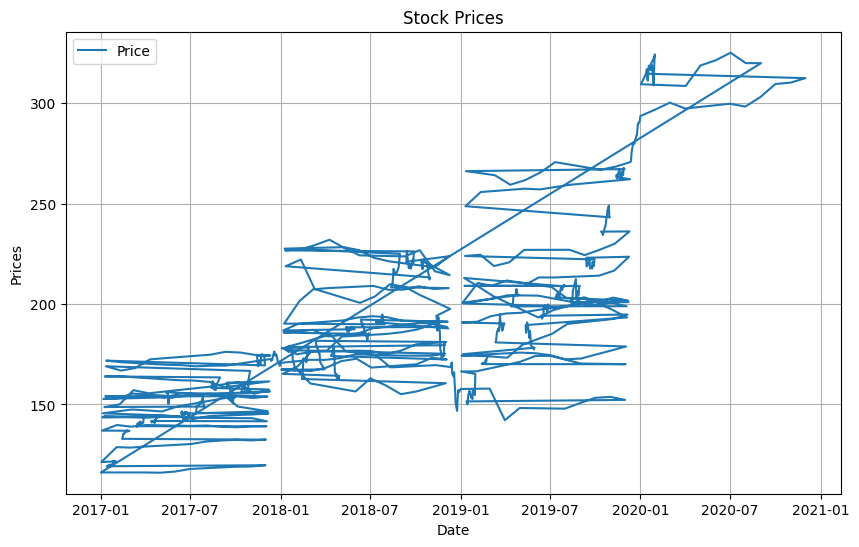

In [14]:
#plot prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(data[['Price']])
plt.title('Stock Prices')
plt.legend(['Price'],loc='upper left')
plt.show()

## Analysis
Above plot shows that closing price has always been between high and low prices, and trending upwards in later year, indicating profit.

## Decomposition

I will divide the data into trend, seasonality, and noise to better understand seasonal components and thier impact.
Decompostion requires proper time intervals or frequencies, here I will check for it.

In [15]:
#print(f'Frequency of the dataframe: {data.index.freq}')

In [16]:
#data_freq = data.resample('B').mean()
#print(data_freq.isna().sum())

In [17]:
#data_freq.shape

In [18]:
#data_freq.fillna(method = 'ffill', inplace = True)

seperating 'Price' column as it will be the only one used for further work.

In [19]:
#price = data_freq['price']

In [20]:
price = data['Price']
price = price.sort_index()

<Figure size 640x480 with 0 Axes>

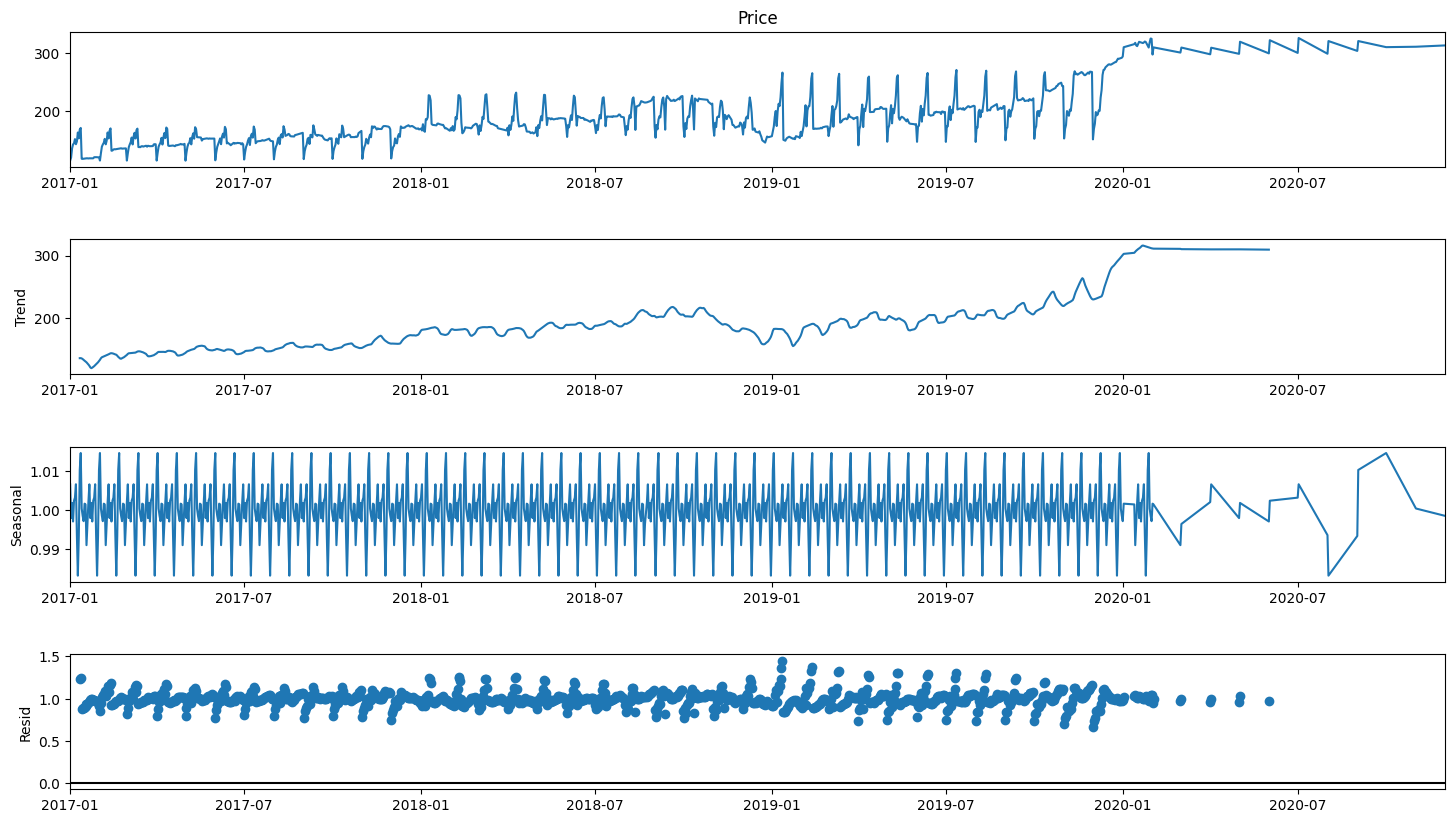

In [21]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(price, model='multiplicative',period=20) 
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

This function uses augmented fuller test to check stationarity of the data.

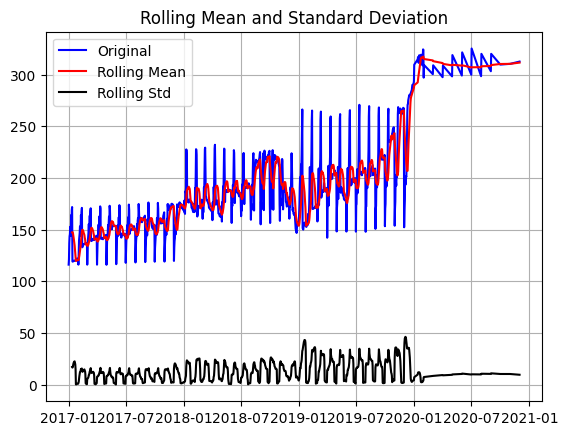

Results of dickey fuller test
Test Statistics                  -0.013950
p-value                           0.957363
No. of lags used                 23.000000
Number of observations used    1110.000000
critical value (1%)              -3.436255
critical value (5%)              -2.864147
critical value (10%)             -2.568158
dtype: float64


In [22]:
sty.test_stationarity(price)

For data to be stationary test statictics has to be smaller than critical value (1%). and p-value less than 0.05. As we can see from above table p-vlaue is greater 0.05 and test statistic is also big which means data is non stationary.

I will try differencing with moving average on the data to see the results.

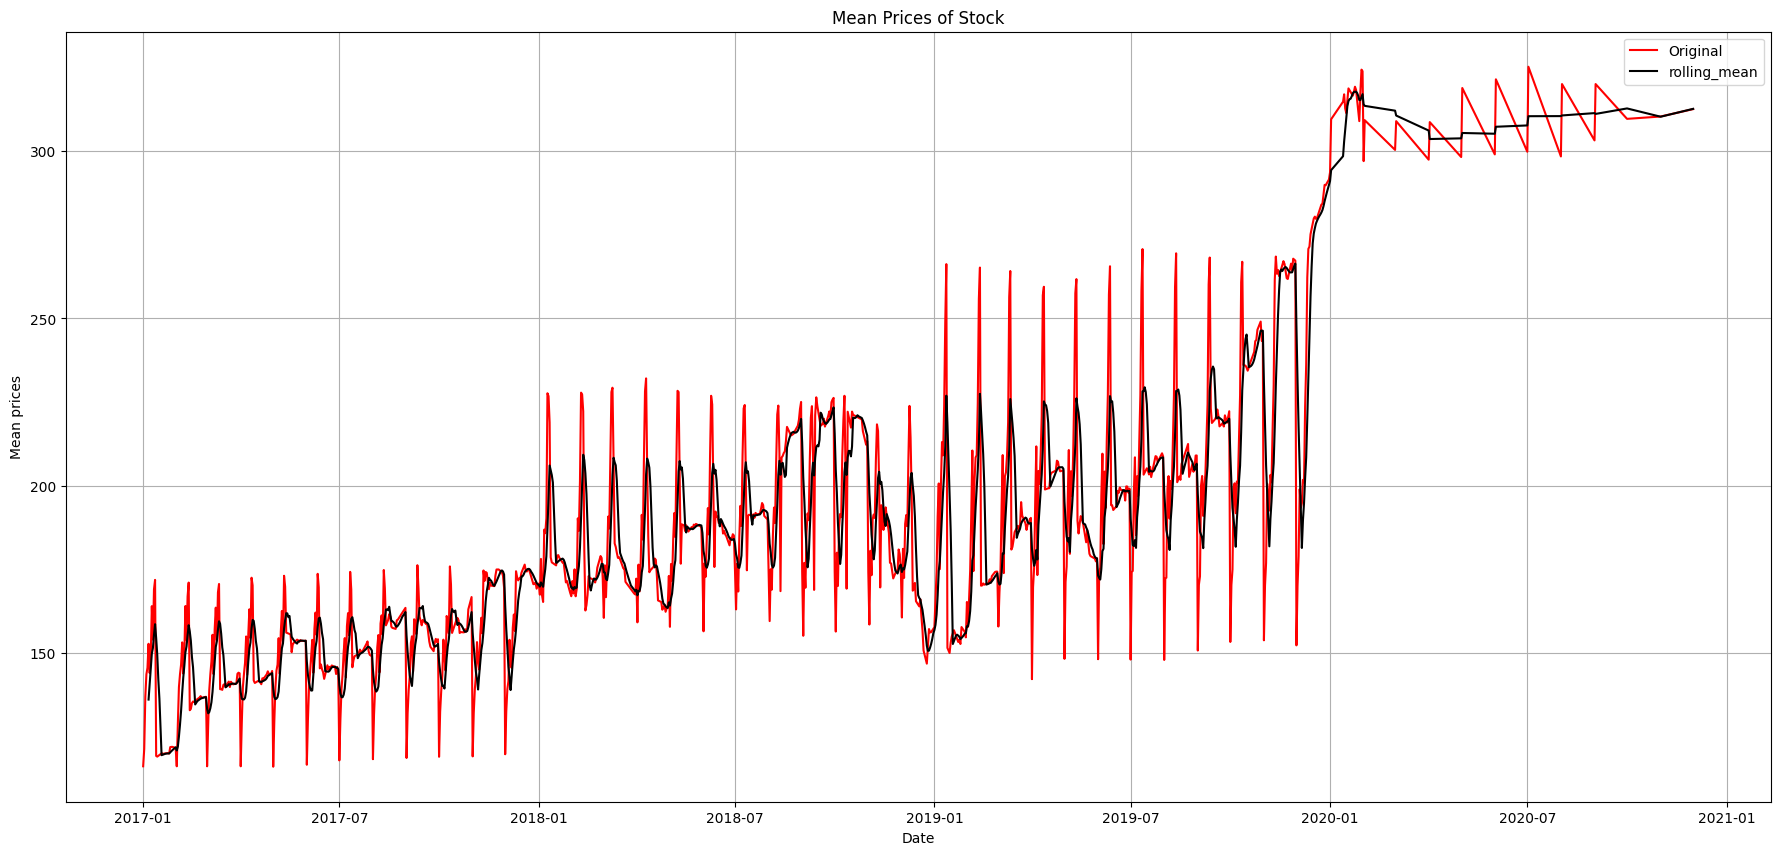

In [23]:
# Moving average method
moving_avg = price.rolling(6).mean()
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(price, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "rolling_mean")
plt.title("Mean Prices of Stock")
plt.xlabel("Date")
plt.ylabel("Mean prices")
plt.legend()
plt.show()

In [24]:
ts_moving_avg_diff = price - moving_avg
ts_moving_avg_diff.dropna(inplace=True)

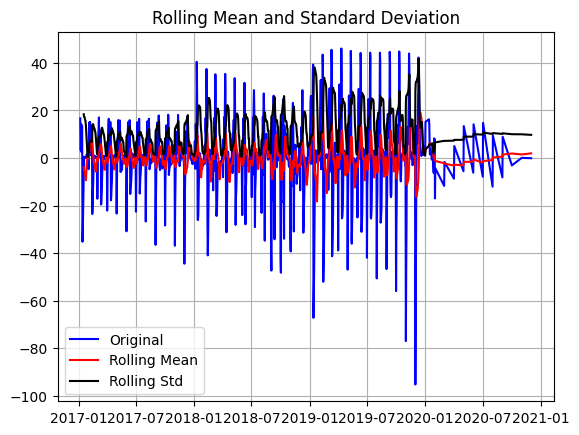

Results of dickey fuller test
Test Statistics               -1.319002e+01
p-value                        1.149170e-24
No. of lags used               2.200000e+01
Number of observations used    1.106000e+03
critical value (1%)           -3.436276e+00
critical value (5%)           -2.864157e+00
critical value (10%)          -2.568163e+00
dtype: float64


In [25]:
sty.test_stationarity(ts_moving_avg_diff)

Test statistics and p-value show that our dataset is stationary now.

## Train test split

In [26]:
#split data into train and training set
#train_data = price[0:(price.index.year==2020).sum()]
#test_data = price[(price.index.year==2020).sum():]

train_data = price[0:907]
test_data = price[907:]

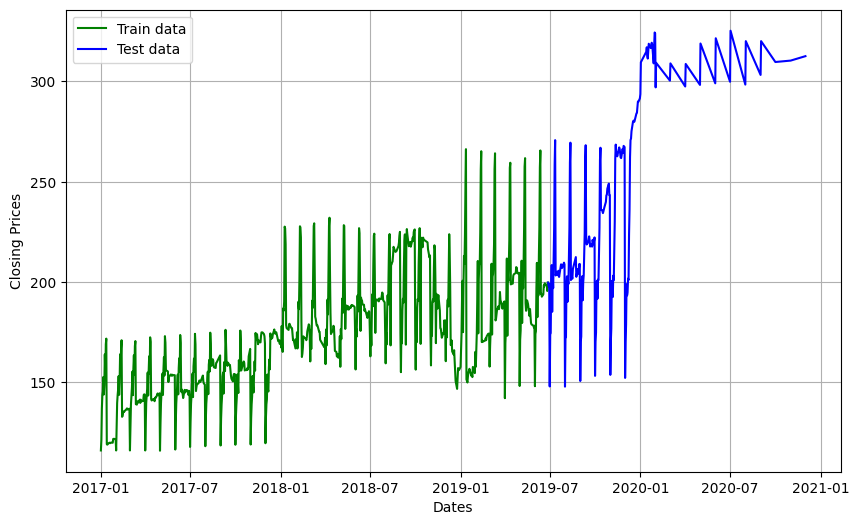

In [27]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9288.600, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8820.378, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8882.261, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8788.756, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=8772.699, Time=0.12 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=8766.575, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=8768.529, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8720.428, Time=0.43 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8719.372, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8720.105, Time=0.19 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8722.512, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8719.618, Time=0.25 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=8723.362, Time=0.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8716.028, Time=0.90 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

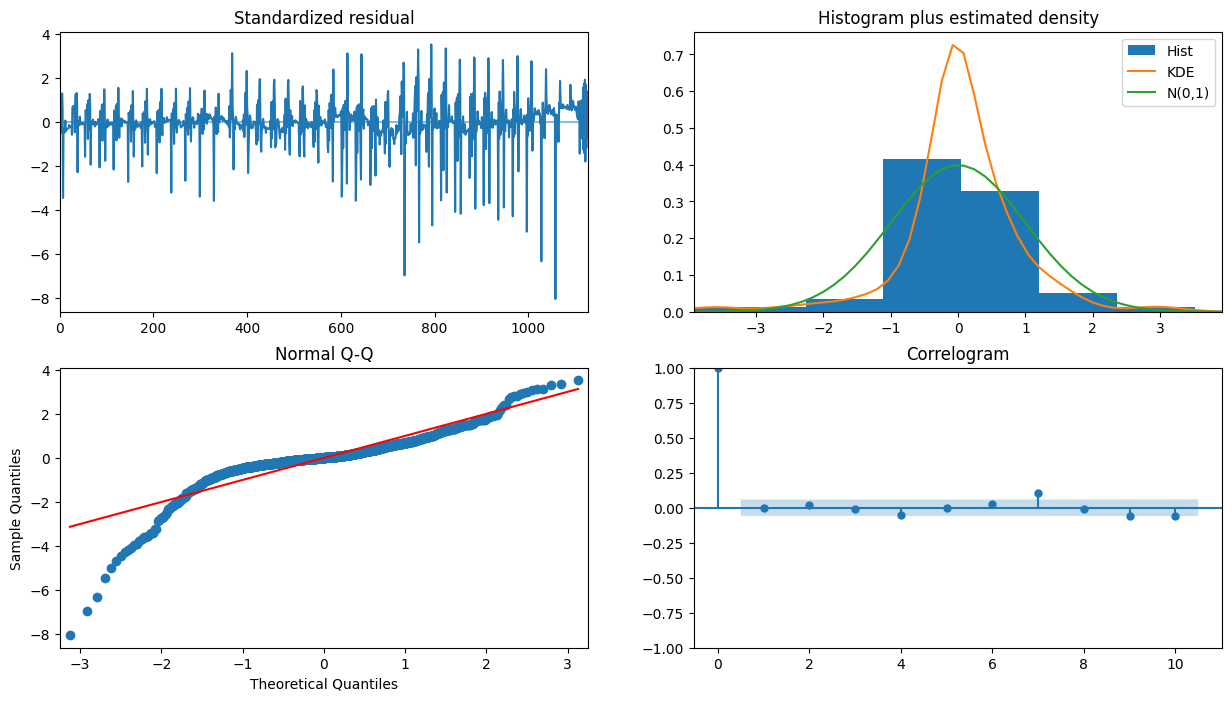

In [28]:
model_autoARIMA = auto_arima(ts_moving_avg_diff, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

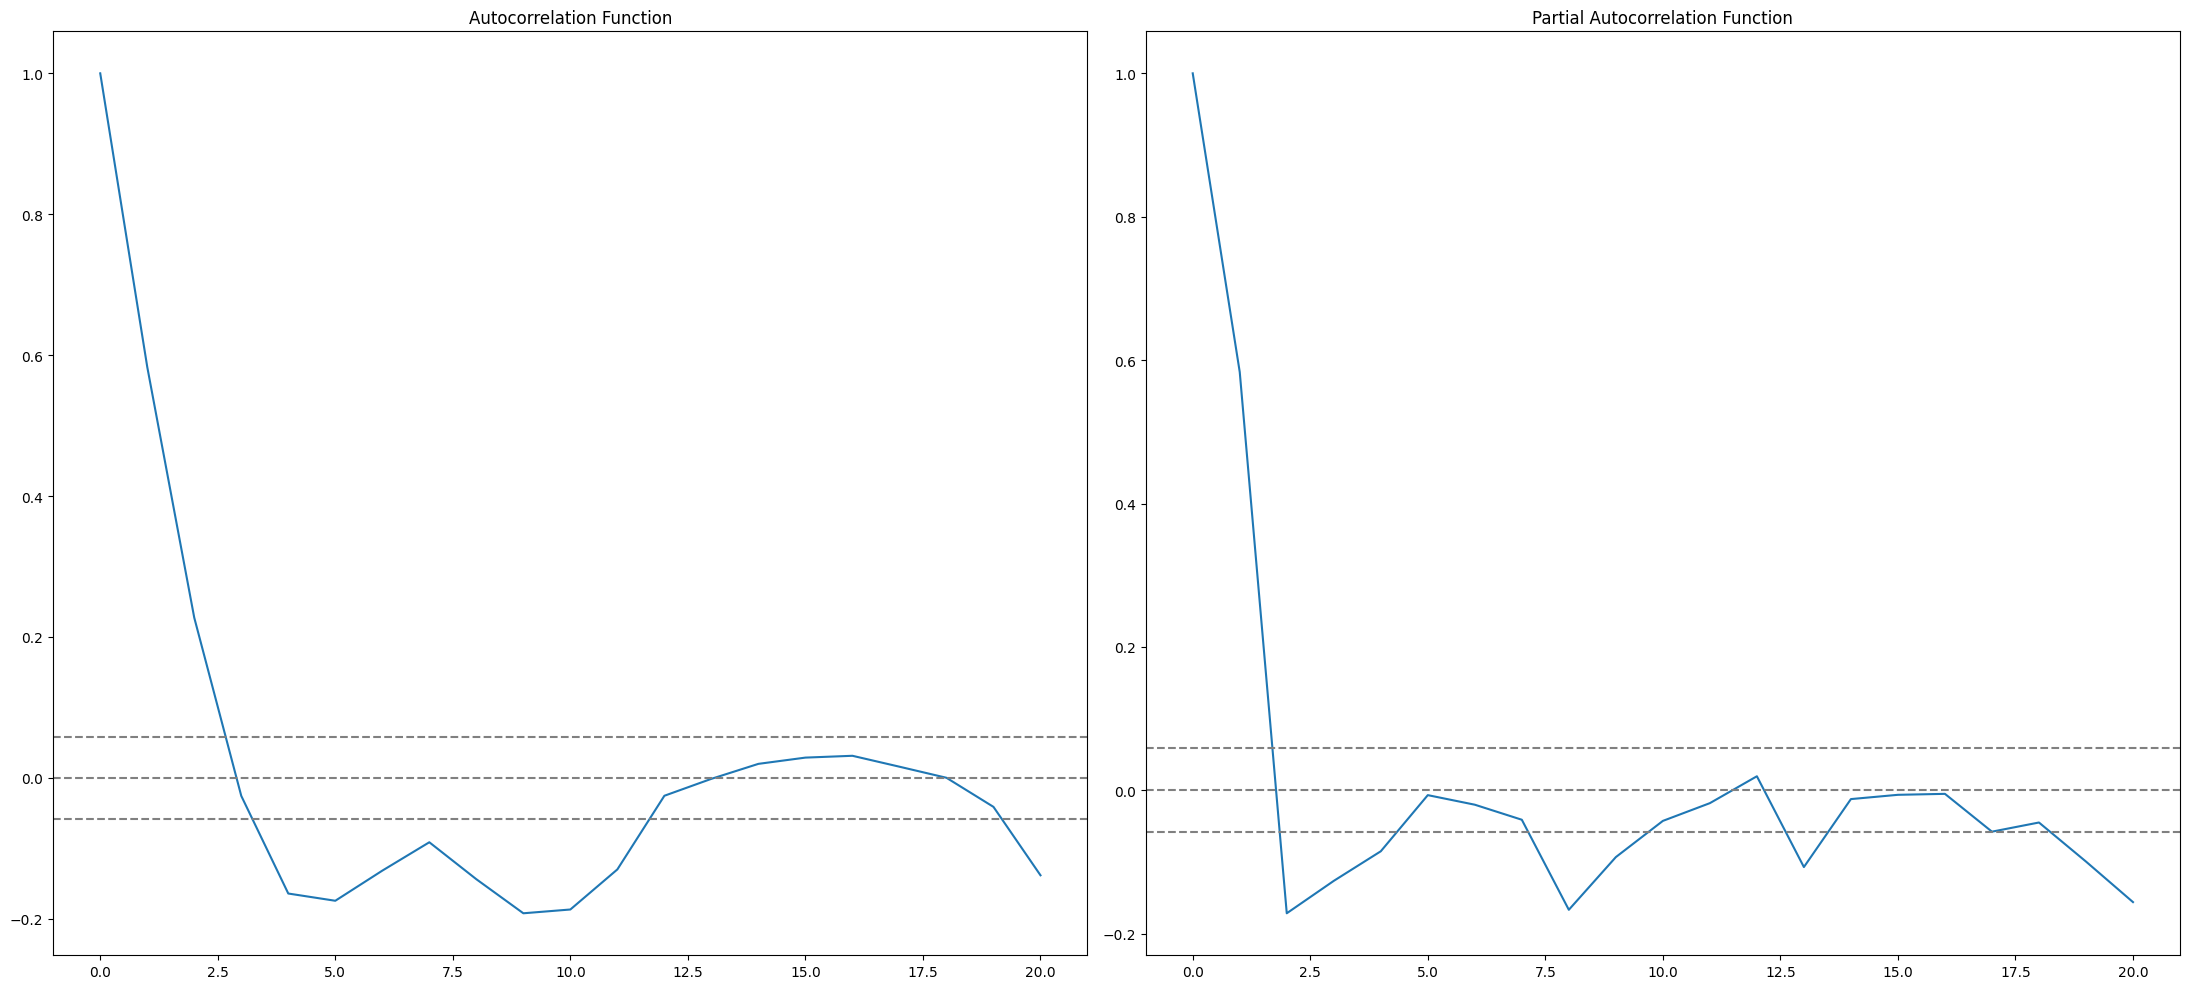

In [29]:
plots.acf_pacf_plot(ts_moving_avg_diff)

In [30]:
#Modeling
# Build Model
model = ARIMA(price, order=(3,0,1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1134
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -4581.870
Date:                Sun, 22 Jan 2023   AIC                           9175.740
Time:                        22:19:58   BIC                           9205.941
Sample:                             0   HQIC                          9187.148
                               - 1134                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.7503     80.770      2.324      0.020      29.443     346.057
ar.L1          1.7519      0.030     58.054      0.000       1.693       1.811
ar.L2         -0.7790      0.058    -13.527      0.0

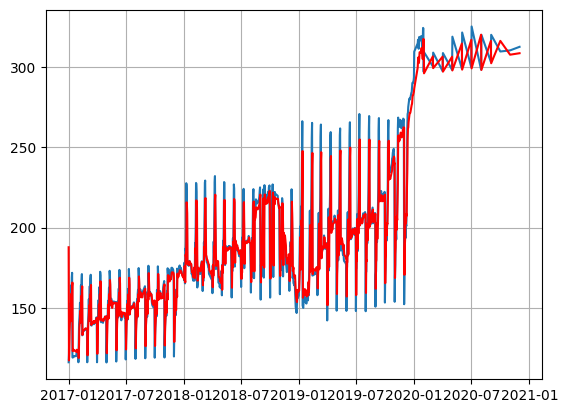

In [31]:
plt.grid(True)
plt.plot(price)
plt.plot(fitted.fittedvalues, color='red')

Comapring original  training data and predicted values we can see that model perform well.

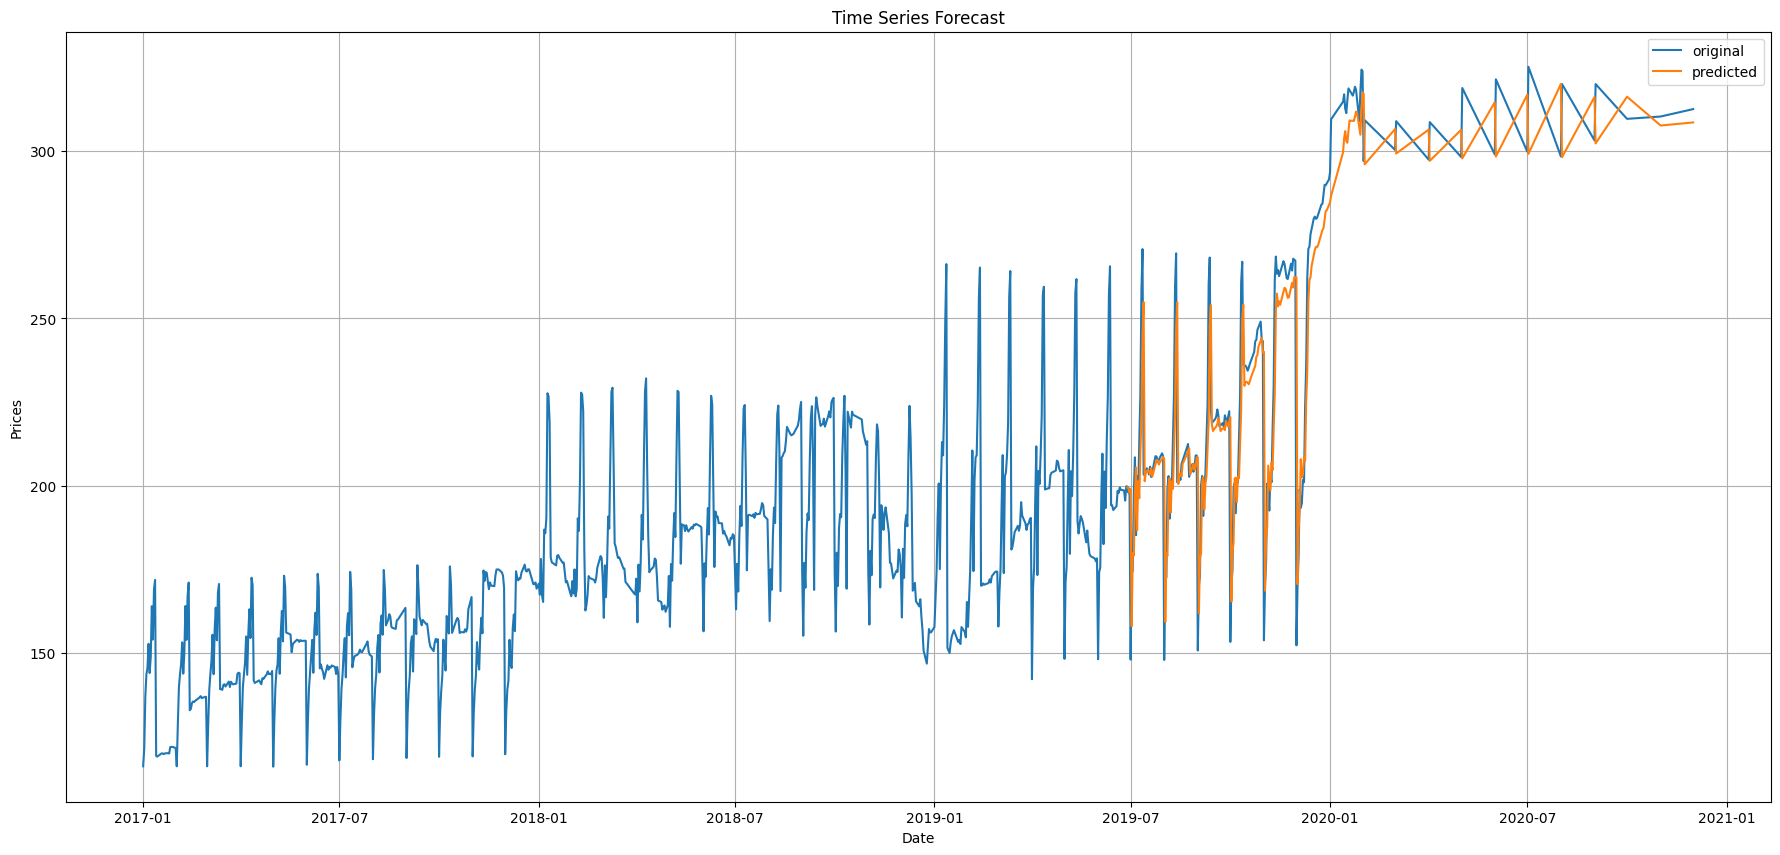

In [32]:
# predict
#test_data

start_index = datetime(2019, 6, 27)
end_index = datetime(2020, 12, 1)
forecast = fitted.predict(start=test_data.index[0], end=test_data.index[-1])

# visualization
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(price.index,price,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [33]:
#Check mean square error
from sklearn.metrics import mean_squared_error
error_arima = mean_squared_error(test_data, forecast)
print("error: " ,error_arima)

error:  299.45970234829224


## SARIMAX Model

In [34]:
autosarimax=auto_arima(ts_moving_avg_diff, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8716.274, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9289.837, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8822.155, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8883.785, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9288.600, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8792.839, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8716.793, Time=0.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8719.182, Time=0.60 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8717.092, Time=0.70 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8800.426, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8762.557, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8716.028, Time=0.70 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8774.313, Time=0.22 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=8717.103, Time=0.93 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept

In [35]:
sarimax_model = SARIMAX(price, order = (3,0+1,1), seasonal_order= (3,0+1,1,7))
sarimax_result = sarimax_model.fit()

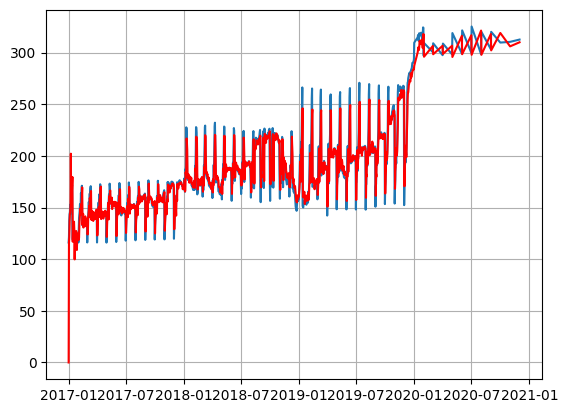

In [36]:
plt.grid(True)
plt.plot(price)
plt.plot(sarimax_result.fittedvalues, color='red')

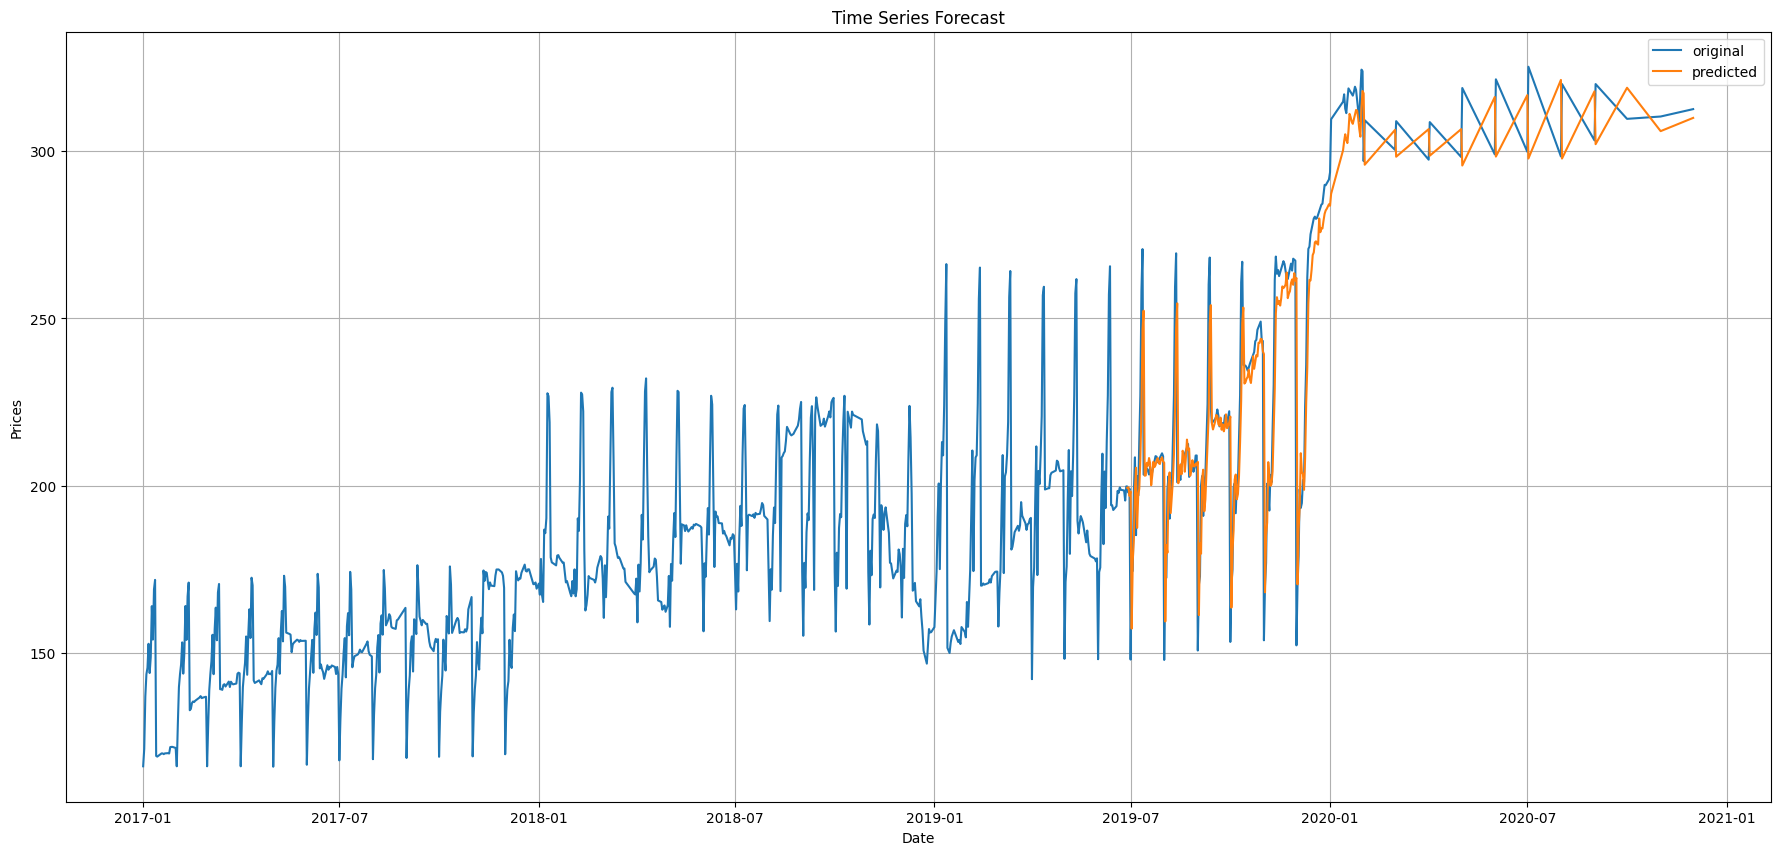

In [37]:
# predict
#test_daa
start_index = datetime(2021, 1, 1)
end_index = datetime(2021, 3, 31)
forecast_sarimax = sarimax_result.predict(start=test_data.index[0], end=test_data.index[-1])

# visualization
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(price.index,price,label = "original")
plt.plot(forecast_sarimax,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [38]:
#Check mean square error
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_data, forecast_sarimax)
print("error: " ,error)

error:  290.4982595290961


## LSTM Model

### 1st Method
This method uses scalecast a library of time series models to train an lstm model.

In [39]:
f = Forecaster(y=price,current_dates=price.index)
f

Forecaster(
    DateStartActuals=2017-01-01T00:00:00.000000000
    DateEndActuals=2020-12-01T00:00:00.000000000
    Freq=None
    N_actuals=1134
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

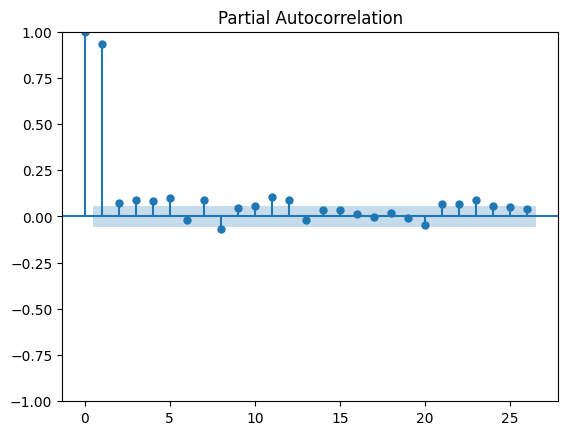

In [40]:
f.plot_pacf(lags=26)
plt.show()

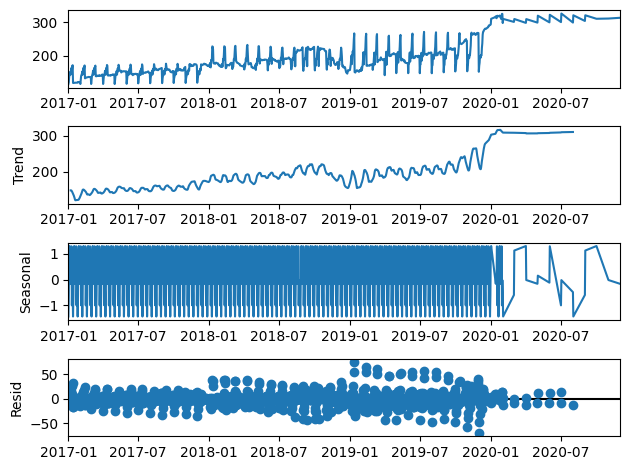

In [41]:
f.seasonal_decompose(period=12).plot()
plt.show()

In [42]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(f'Test stats: {stat}')
print(f'p-value: {pval}')

Test stats: -0.013950266074948571
p-value: 0.9573630910460271


In [43]:
f.set_test_length(64)       # 1. 12 observations to test the results
f.generate_future_dates(64) # 2. 12 future points to forecast
f.set_estimator('lstm') 

Epoch 1/50
996/996 [==============================] - 4s 3ms/step - loss: 0.1209
Epoch 2/50
996/996 [==============================] - 3s 3ms/step - loss: 0.1104
Epoch 3/50
996/996 [==============================] - 3s 3ms/step - loss: 0.1073
Epoch 4/50
996/996 [==============================] - 4s 4ms/step - loss: 0.1057
Epoch 5/50
996/996 [==============================] - 4s 4ms/step - loss: 0.1046
Epoch 6/50
996/996 [==============================] - 4s 4ms/step - loss: 0.1034
Epoch 7/50
996/996 [==============================] - 7s 7ms/step - loss: 0.1017
Epoch 8/50
996/996 [==============================] - 6s 6ms/step - loss: 0.1011
Epoch 9/50
996/996 [==============================] - 6s 6ms/step - loss: 0.1004
Epoch 10/50
996/996 [==============================] - 6s 6ms/step - loss: 0.0994
Epoch 11/50
996/996 [==============================] - 5s 5ms/step - loss: 0.0989
Epoch 12/50
996/996 [==============================] - 6s 6ms/step - loss: 0.0982
Epoch 13/50
996/996 [====

1060/1060 [==============================] - 4s 4ms/step - loss: 0.0624
Epoch 50/50
1060/1060 [==============================] - 4s 4ms/step - loss: 0.0621


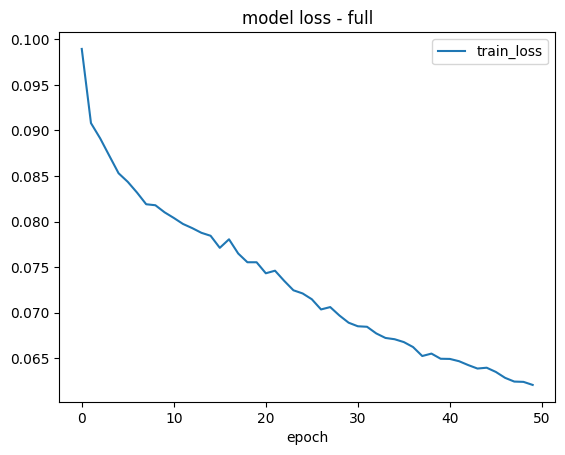

34/34 [==============================] - 0s 3ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

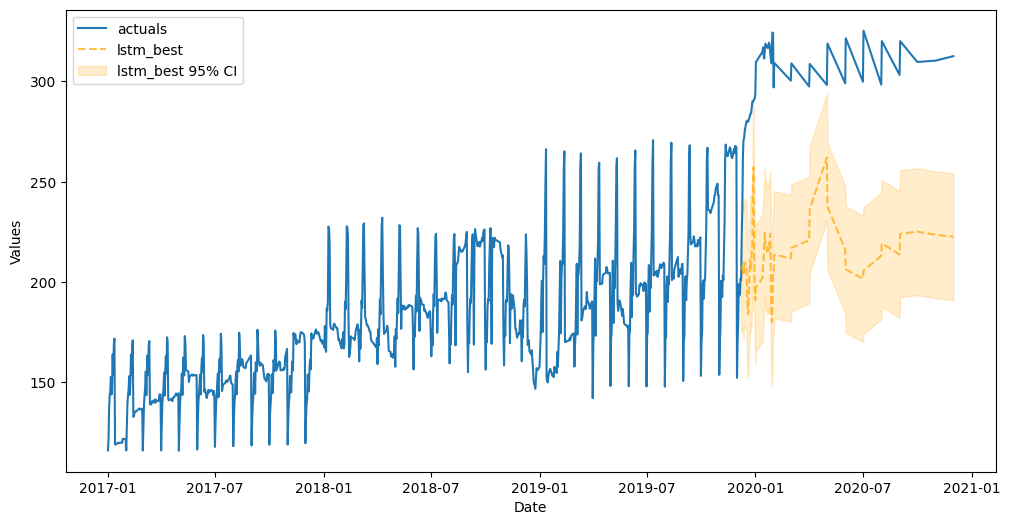

In [44]:
f.manual_forecast(call_me='lstm_best',
                  lags=10,
                  batch_size=1,
                  epochs=50,
                  shuffle=True,
                  activation='relu',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(100,)*2,
                  dropout=(0,)*2,
                  plot_loss=True)
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)

It can be seen from above graph that the result is not very good. Next method will be to build an LSTM model and train, test the data to see the resuls.

### 2nd Method

#### Train test split

In [98]:
#split data into train and training set
#Seq_data = data.iloc[::-1]
#train = Seq_data[0:(Seq_data.index.year==2020).sum()]
#test = Seq_data[(Seq_data.index.year==2020).sum():]
#train_sep = train[['Price']]
#test_sep = test[['Price']]
Seq_data = data.iloc[::-1]
Seq_data = Seq_data.sort_index()
train = Seq_data[0:907]
test = Seq_data[907:]
train_sep = train[['Price']]
test_sep = test[['Price']]

In [99]:
test.shape

(227, 7)

#### Scaling the dataset

In [100]:
scaled = StandardScaler()
train_scaled = scaled.fit_transform(train_sep)
test_scaled = scaled.transform(test_sep)

In [101]:
input = 1
features = 1

final_train = TimeseriesGenerator(train_scaled, train_scaled, length=input, batch_size=1)
final_test = TimeseriesGenerator(test_scaled, test_scaled, length=input, batch_size=1)

In [102]:
model = tsm.lstm_model(input,features)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 100)            40800     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [103]:
history = model.fit(final_train,epochs=50)

Epoch 1/50
906/906 [==============================] - 3s 2ms/step - loss: 0.3372
Epoch 2/50
906/906 [==============================] - 1s 2ms/step - loss: 0.2392
Epoch 3/50
906/906 [==============================] - 1s 2ms/step - loss: 0.2265
Epoch 4/50
906/906 [==============================] - 1s 2ms/step - loss: 0.2277
Epoch 5/50
906/906 [==============================] - 1s 2ms/step - loss: 0.2301
Epoch 6/50
906/906 [==============================] - 1s 2ms/step - loss: 0.2263
Epoch 7/50
906/906 [==============================] - 2s 2ms/step - loss: 0.2285
Epoch 8/50
906/906 [==============================] - 2s 2ms/step - loss: 0.2208
Epoch 9/50
906/906 [==============================] - 1s 2ms/step - loss: 0.2200
Epoch 10/50
906/906 [==============================] - 1s 2ms/step - loss: 0.2134
Epoch 11/50
906/906 [==============================] - 2s 2ms/step - loss: 0.2209
Epoch 12/50
906/906 [==============================] - 1s 2ms/step - loss: 0.2194
Epoch 13/50
906/906 [====

In [104]:
model.evaluate(final_test)

226/226 [==============================] - 1s 1ms/step - loss: 3.2328


3.2327988147735596

226/226 [==============================] - 0s 898us/step


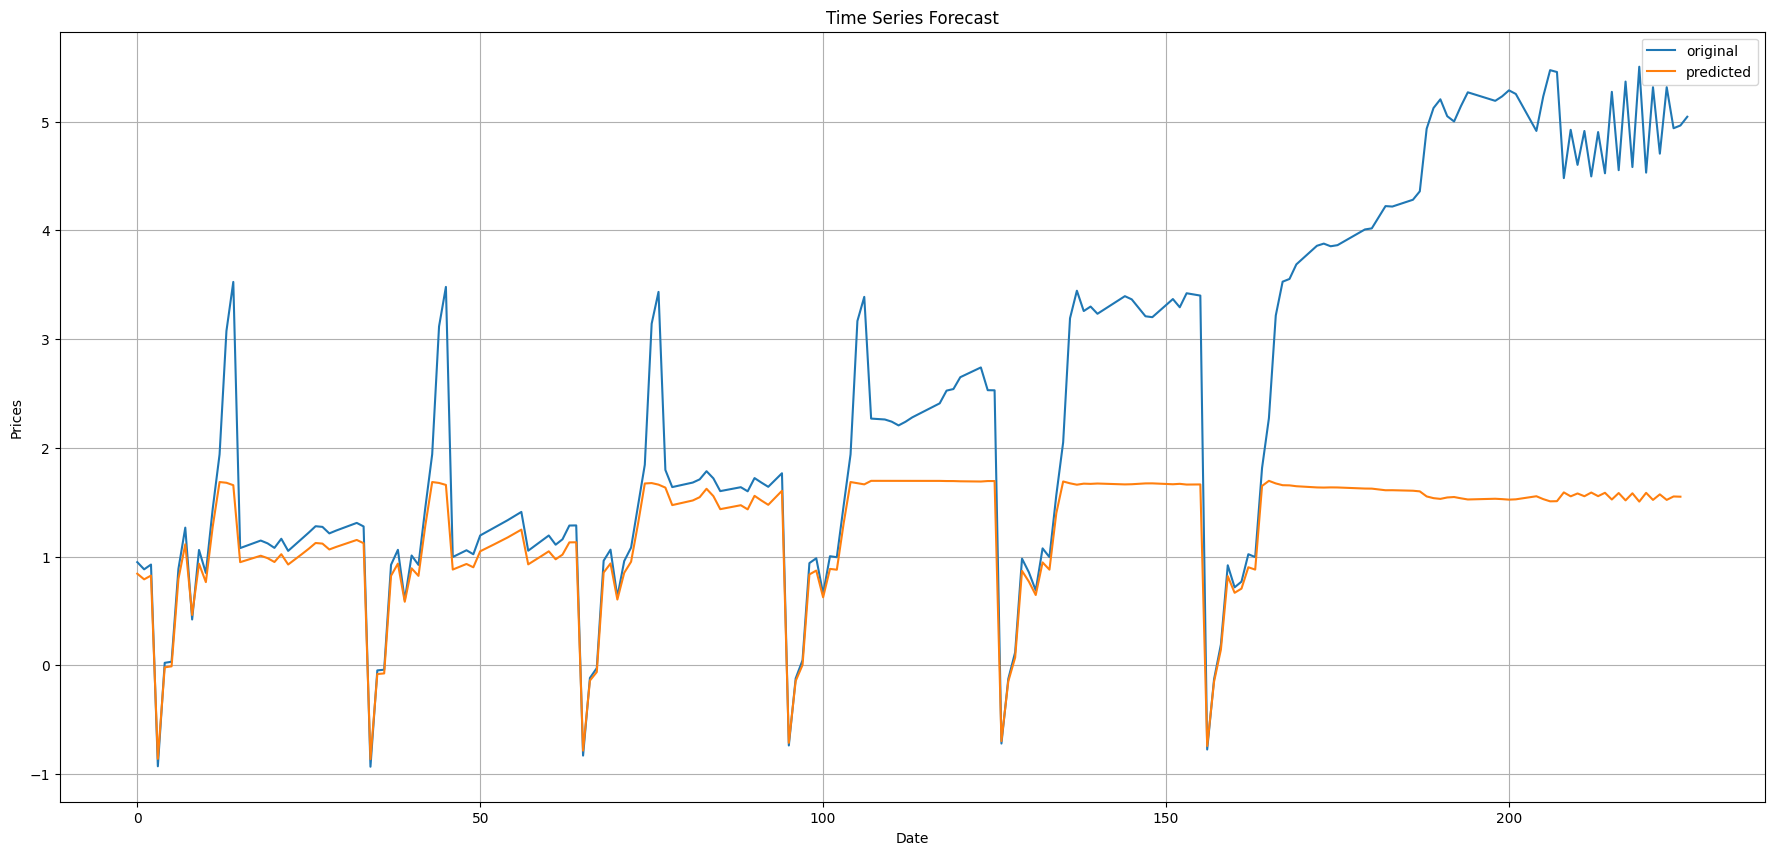

In [105]:
y_pred = model.predict(final_test)
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(test_scaled,label = "original")
plt.plot(y_pred,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

## Bollinger Bands

### Analysis
Three models Arima,Sarimax, and LSTM were train and tested and LSTM has outperformed other Arima and Sarimax and will be chosen 
for bollinger bands evaluation.

In [111]:
test.drop(test.tail(1).index,inplace=True)

In [113]:
test['predicted'] = scaled.inverse_transform(y_pred).flatten()

In [114]:
bands_data=fs.bollinger_bands(20,test)
bands_data.sort_index()

,volume,Price,high,count_agg,low,open,change,predicted,sma,std,upper,lower
Date,,,,,,,,,,,,
2019-06-28,20.900000,199.740000,201.570000,1,199.570000,200.290000,-0.030000,196.819214,NaN,NaN,NaN,NaN
2019-06-29,31.110000,197.920000,199.500000,1,197.050000,198.680000,-0.910000,195.388824,NaN,NaN,NaN,NaN
2019-06-30,29.846667,199.130000,201.163333,0,198.250000,200.176667,0.003333,196.335312,NaN,NaN,NaN,NaN
2019-07-01,56.056667,148.040000,148.700000,0,145.210000,147.266667,1.276667,149.926239,NaN,NaN,NaN,NaN
2019-07-02,28.240000,174.240000,175.550000,1,172.860000,174.800000,0.030000,173.100235,NaN,NaN,NaN,NaN
2019-07-03,20.810000,174.520000,175.480000,1,174.100000,174.740000,-0.580000,173.353439,NaN,NaN,NaN,NaN
2019-07-04,20.980000,198.033333,198.143333,0,196.066667,196.440000,0.970000,195.476730,NaN,NaN,NaN,NaN
2019-07-05,32.440000,208.480000,208.840000,1,203.500000,204.290000,-1.540000,204.263123,NaN,NaN,NaN,NaN
2019-07-06,22.530000,185.220000,185.470000,1,182.150000,183.080000,1.470000,186.363953,NaN,NaN,NaN,NaN


In [115]:
bands_data.tail()

,volume,Price,high,count_agg,low,open,change,predicted,sma,std,upper,lower
Date,,,,,,,,,,,,
2020-08-02,29.42,320.03,323.40,1,318.18,322.38,-1.59,215.504166,216.316043,0.838754,217.993552,214.638534
2020-09-01,33.09,303.19,304.42,1,297.38,297.50,1.61,216.905121,216.365782,0.842915,218.051612,214.679952
2020-09-02,29.42,320.03,323.40,0,318.18,322.38,-1.59,215.504166,216.332438,0.863952,218.060341,214.604535
2020-10-01,42.62,309.63,310.40,1,306.22,307.11,2.12,216.374207,216.329614,0.863706,218.057026,214.602203
2020-11-01,35.22,310.33,312.63,1,308.28,310.85,0.23,216.316010,216.360383,0.850987,218.062357,214.658408


In [116]:
print(type(bands_data))

<class 'pandas.core.frame.DataFrame'>


In [117]:
bands_data['buy'] = fs.get_signal(bands_data)[0]
bands_data['sell'] = fs.get_signal(bands_data)[1]

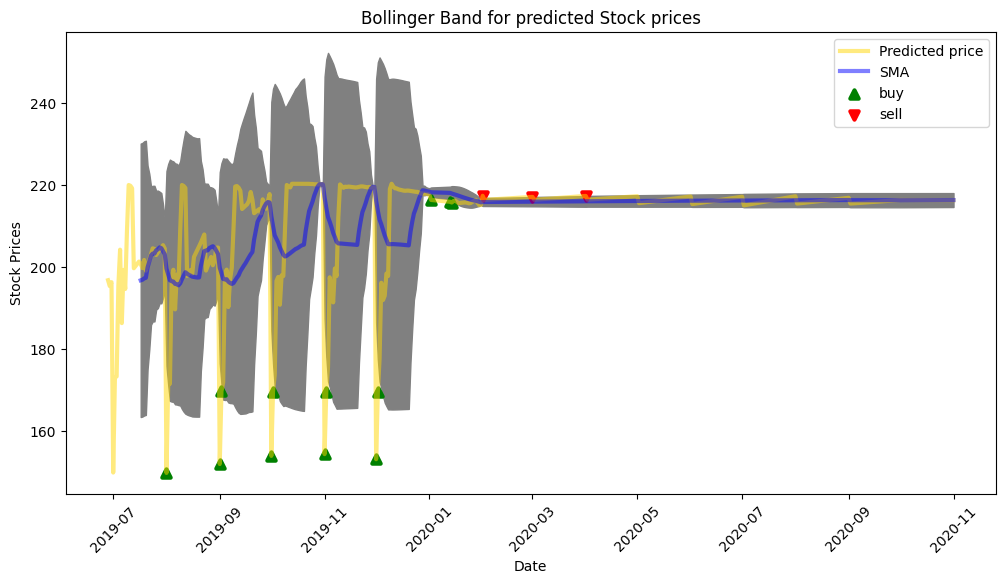

In [121]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
x_axis = bands_data.index
ax.fill_between(x_axis, bands_data['upper'],bands_data['lower'],color='grey')
ax.plot(x_axis, bands_data['predicted'],color = 'gold',lw=3,label='Predicted price', alpha = 0.5)
ax.plot(x_axis, bands_data['sma'],color = 'blue',lw=3,label='SMA', alpha = 0.5)
ax.scatter(x_axis, bands_data['buy'],color='green',lw=3,label='buy',marker='^', alpha = 1)
ax.scatter(x_axis, bands_data['sell'],color='red',lw=3,label='sell',marker='v', alpha = 1)
ax.set_title('Bollinger Band for predicted Stock prices')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Prices')
plt.xticks(rotation = 45)
ax.legend()
plt.show()

## Conclusion
Using Bollinger Bands on predicted prices for 2021 data do not yield any buy or cell signal, this can only be due to the fact that only one year worth of data is available for training, However using more data could imporve the performance.